# 1. Install important dependencies

In [1]:
# Install necessary packages
!pip install transformers nltk datasets numpy seaborn pandas scikit-learn os-sys matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 KB 41.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 93.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 21.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.4 MB/s eta 0:00:00


# 2. Import Dependencies

In [1]:
import pandas as pd
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# To import the Transformer Models
from transformers import AutoTokenizer, DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# to convert to Dataset datatype - the transformers library does not work well with pandas
from datasets import Dataset

### 2.1 Load the dataset

In [190]:
# The dataset does not contain class labels, so we need to explicitly provide it
df=pd.read_csv(os.path.join('ag-news-classification-dataset','train.csv'),names=['label','Title','Description'])
df.head()

,label,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


### 2.2 Data statistics

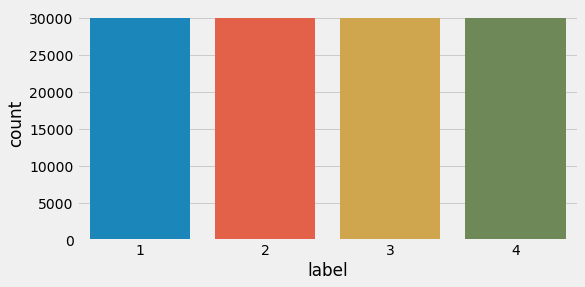

In [4]:
# checking for unbalanced dataset
plt.style.use('fivethirtyeight')
plt.figure(figsize=(8,4))
sns.countplot(x=df['label'])
plt.show()

### 2.3 Check for null values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   label        120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


# 3. Data Preprocessing

In [191]:
# concatinating the 'title' and 'description' column
df['text']=(df['Title']+df['Description'])
df.drop(columns=['Title','Description'],axis=1,inplace=True)
df.head()

,label,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [192]:
# Text before preprocessing - contains symbols like ()\-,.' which is not useful
df['text'][1]

'Carlyle Looks Toward Commercial Aerospace (Reuters)Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.'

### 3.1 Remove Punctuations

In [8]:
import re   # regular expression can be used to remove any punctuation or unnecessary symbols

In [9]:
def remove_punctuations(text):
     text=re.sub(r'[\\-]',' ',text)
     text=re.sub(r'[,.?;:\'(){}!|0-9]','',text)
     return text

# the apply method applies a function along an axis of dataframe
df['text']=df['text'].apply(remove_punctuations)
df.head()

,label,text
0,3,Wall St Bears Claw Back Into the Black Reuters...
1,3,Carlyle Looks Toward Commercial Aerospace Reut...
2,3,Oil and Economy Cloud Stocks Outlook ReutersRe...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,Oil prices soar to all time record posing new ...


In [11]:
import nltk

# downloading corpus only would work
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> d

Download which package (l=list; x=cancel)?
  Identifier> all


       | 
       | Downloading package abc to /root/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /root/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /root/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to /root/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /root/nltk_data...
       | Downloading package biocreative_ppi to /root/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to /root/nltk_data...
       |   Unzipping models/bllip_wsj_no_aux.zip.
       | Downloading package book_grammars to /root/nltk_data...
       |   Un


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

### 3.2 Remove StopWords

In [10]:
from nltk.corpus import stopwords

# english stopwords
stopw=stopwords.words('english')
stopw[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [11]:
def remove_stopwords(text):
    clean_text=[]
    for word in text.split(' '):
        if word not in stopw:
            clean_text.append(word)
    return ' '.join(clean_text)

# remove stopwords
df['text']=df['text'].apply(remove_stopwords)

# the class label in dataset contains labels as 1,2,3,4 but the model needs 0,1,2,3, so we subtract 1 from all
df['label']=df['label'].apply(lambda x:x-1)
df.head()

,label,text
0,2,Wall St Bears Claw Back Into Black ReutersReut...
1,2,Carlyle Looks Toward Commercial Aerospace Reut...
2,2,Oil Economy Cloud Stocks Outlook ReutersReuter...
3,2,Iraq Halts Oil Exports Main Southern Pipeline ...
4,2,Oil prices soar time record posing new menace ...


In [12]:
df['text'][1]   # this is the final preprocessed text

'Carlyle Looks Toward Commercial Aerospace ReutersReuters   Private investment firm Carlyle Group reputation making well timed occasionally controversial plays defense industry quietly placed bets another part market'

### 3.3 Split the data into training and testing sets

In [13]:
from sklearn.model_selection import train_test_split

# since training on the full dataset(120,000 samples) would be take so long, the train size is only taken to be 30%
train_df,test_df=train_test_split(df[['text','label']],train_size=.3,shuffle=True)
test_df=test_df[:10000]

In [14]:
train_df.shape,test_df.shape    # training set has 36000 samples and testing set has 10000 samples

((36000, 2), (10000, 2))

### 3.4 Load a pre-built tokenizer and convert to tokens

In [18]:
# load tokenizer from bert base uncased model available from huggingface.co
model_name='bert-base-uncased'
tokenizer=AutoTokenizer.from_pretrained(model_name)

In [16]:
def preprocess_function(examples):
    """
    Tokenizes the given text

    input -> dataset (columns = text, label)
    output -> tokenized dataset (columns = text, label, input, attention)
    """
    return tokenizer(examples["text"], truncation=True)

def pipeline(dataframe):
    """
    Prepares the dataframe so that it can be given to the transformer model
    
    input -> pandas dataframe
    output -> tokenized dataset (columns = text, label, input, attention)
    """    
    # This step isn't mentioned anywhere but is vital as Transformers library only seems to work with this Dataset data type
    dataset = Dataset.from_pandas(dataframe, preserve_index=False)
    tokenized_ds = dataset.map(preprocess_function, batched=True)
    tokenized_ds = tokenized_ds.remove_columns('text')
    return tokenized_ds

In [20]:
# create pipeline for training data and testing data
tokenized_train = pipeline(train_df)
tokenized_test = pipeline(test_df)

Map:   0%|          | 0/36000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

# 4. Load a pre-trained model

### 4.1 Adjust Model training arguments

In [ ]:
# load berd-based-uncased model for fine tuning
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# adjust the training arguments
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy = 'epoch',
    optim='adamw_torch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
)

In [22]:
# create the trainer from Trainer class in transformer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

loading configuration file config.json from cache at C:\Users\sagni/.cache\huggingface\hub\models--bert-base-uncased\snapshots\0a6aa9128b6194f4f3c4db429b6cb4891cdb421b\config.json
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache"

### 4.2 Train the model

In [22]:
trainer.train()

***** Running training *****
  Num examples = 36000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6750
  Number of trainable parameters = 109485316
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.418700
1000,0.292300
1500,0.267500
2000,0.275500
2500,0.229600
3000,0.180200
3500,0.177600
4000,0.195700
4500,0.180700
5000,0.116000


Saving model checkpoint to ./results/checkpoint-2250
Configuration saved in ./results/checkpoint-2250/config.json
Model weights saved in ./results/checkpoint-2250/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-2250/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-2250/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-4500
Configuration saved in ./results/checkpoint-4500/config.json
Model weights saved in ./results/checkpoint-4500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-4500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-4500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-6750
Configuration saved in ./results/checkpoint-6750/config.json
Model weights saved in ./results/checkpoint-6750/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-6750/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-6750/special

TrainOutput(global_step=6750, training_loss=0.20428894438566986, metrics={'train_runtime': 1527.4046, 'train_samples_per_second': 70.708, 'train_steps_per_second': 4.419, 'total_flos': 3554209069377408.0, 'train_loss': 0.20428894438566986, 'epoch': 3.0})

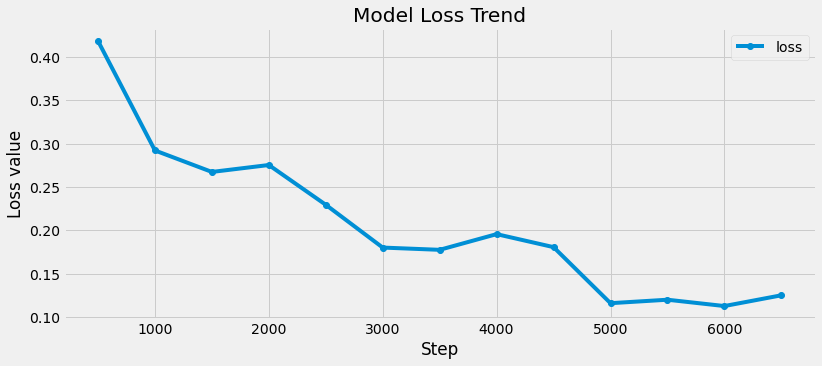

In [184]:
model_loss=pd.read_csv('loss.csv')
plt.figure(figsize=(12,5))
plt.plot(model_loss['Step'],model_loss['Training Loss'],label='loss',marker='o')
plt.xlabel('Step')
plt.ylabel('Loss value')
plt.legend()
plt.title('Model Loss Trend')
plt.show()

### 4.3 Evaluate the Model

In [23]:
# create tokenized text for test dataset
tokenized_test = pipeline(test_df)
tokenized_test = tokenized_test.remove_columns('label')

# input the tokenized text to the trainer to get predictions
preds = trainer.predict(tokenized_test)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

***** Running Prediction *****
  Num examples = 10000
  Batch size = 8


  0%|          | 0/1250 [00:00<?, ?it/s]

In [25]:
import numpy as np
from sklearn.metrics import classification_report,confusion_matrix

# the maximum value in the prediction is the predicted class label
preds_flat = [np.argmax(x) for x in preds[0]]

In [33]:
# The model got a precision of 96%, 97%, 90% and 89% on class labels 0,1,2,3 and similarly for recall, f1-score, support
print(classification_report(test_df['label'], preds_flat))  # accuracy: 93%

              precision    recall  f1-score   support

           0       0.96      0.92      0.94      2530
           1       0.97      0.99      0.98      2409
           2       0.90      0.91      0.90      2584
           3       0.89      0.91      0.90      2477

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



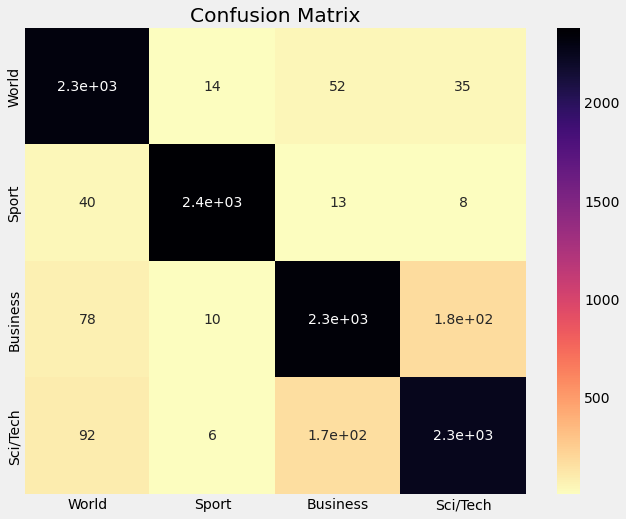

In [100]:
plt.figure(figsize=(10,8))

# plot the heat map 
sns.heatmap(
    confusion_matrix(test_df['label'], preds_flat),
    annot=True,
    xticklabels=['World','Sport','Business','Sci/Tech'],
    yticklabels=['World','Sport','Business','Sci/Tech'],
    cmap=plt.cm.magma_r
)
plt.title('Confusion Matrix')
plt.show()

### 4.4 Test model on random predictions

In [101]:
import random

In [153]:
num=random.randint(0,len(test_df)-101)
tokenized_test = pipeline(test_df[num:num+100]).remove_columns('label')

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [154]:
# accuracy on random 100 samples from test dataset: 99% which is great!
preds=trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]
print(classification_report(test_df['label'][num:num+100], preds_flat))

***** Running Prediction *****
  Num examples = 100
  Batch size = 8


  0%|          | 0/13 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      0.96      0.98        26
           1       1.00      1.00      1.00        15
           2       0.97      1.00      0.99        33
           3       1.00      1.00      1.00        26

    accuracy                           0.99       100
   macro avg       0.99      0.99      0.99       100
weighted avg       0.99      0.99      0.99       100



### 4.5 Manually compare predictions on sample test data

In [118]:
class_labels=['World','Sports','Business','Sci/Tech']

In [179]:
num=random.randint(0,len(test_df)-1)
tokenized_test = pipeline(test_df[num:num+10]).remove_columns('label')
preds=trainer.predict(tokenized_test)
preds_flat = [np.argmax(x) for x in preds[0]]

# generating predicted class and actual class for 10 random samples from test dataset
print('Prediction\tActual\n----------------------')
for i in range(len(preds_flat)):
    print(class_labels[preds_flat[i]],' ---> ',class_labels[test_df['label'].values[num+i]])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

***** Running Prediction *****
  Num examples = 10
  Batch size = 8


  0%|          | 0/2 [00:00<?, ?it/s]

Prediction	Actual
----------------------
Sci/Tech  --->  Sci/Tech
World  --->  World
World  --->  World
World  --->  World
World  --->  World
Business  --->  Business
Business  --->  Business
Sci/Tech  --->  Sci/Tech
Sports  --->  Sports
Business  --->  Business


# 5. Save Model

In [38]:
# save_model method saves the model along with its metadata in the specified path
trainer.save_model('models')

Saving model checkpoint to models
Configuration saved in models/config.json
Model weights saved in models/pytorch_model.bin
tokenizer config file saved in models/tokenizer_config.json
Special tokens file saved in models/special_tokens_map.json


# 6. Load Model

In [185]:
# for loading model, we just need to specify the path of the folder for saved model
model = AutoModelForSequenceClassification.from_pretrained('models')
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

loading configuration file models\config.json
Model config BertConfig {
  "_name_or_path": "models",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file 